In [1]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [2]:
%reload_ext autoreload
%autoreload 2

from datetime import datetime

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

import lightgbm as lgb
from features import woe

basepath   = os.path.expanduser('../')

# train and validation fold
# TRAIN_PATH = os.path.join(basepath, 'data/processed/application_train_fold.feather')
# TEST_PATH  = os.path.join(basepath, 'data/processed/application_val_fold.feather')

# full training
TRAIN_PATH = os.path.join(basepath, 'data/processed/application_train.feather')
TEST_PATH  = os.path.join(basepath, 'data/processed/application_test.feather')

# MODEL PRESET
MODEL_PRESET   = 'baseline'

## Load Processed Data

In [3]:
%%time

tr = pd.read_feather(f'{TRAIN_PATH}')
te = pd.read_feather(f'{TEST_PATH}')

CPU times: user 207 ms, sys: 146 ms, total: 353 ms
Wall time: 1.98 s


In [4]:
# concat training and test set
data   = pd.concat((tr, te))
ntrain = len(tr) 

del tr, te
gc.collect();

## Feature Engineering

In [5]:
%%time

# deviation in three external scores
data.loc[:, 'EXT_SOURCE_DEV']  = data.loc[:, ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].apply(np.std, axis=1)

# feature interactions
data.loc[:, 'EXT_3_1'] = data.loc[:, 'EXT_SOURCE_3'] / data.loc[:, 'EXT_SOURCE_1']
data.loc[:, 'EXT_3_2'] = data.loc[:, 'EXT_SOURCE_3'] / data.loc[:, 'EXT_SOURCE_2']
data.loc[:, 'EXT_2_1'] = data.loc[:, 'EXT_SOURCE_2'] / data.loc[:, 'EXT_SOURCE_1']

CPU times: user 22.2 s, sys: 581 ms, total: 22.8 s
Wall time: 22.5 s


In [6]:
# remove feature values with frequency less 100
for f in data.select_dtypes(include=['int8']).columns:
    if data[f].nunique() > 10:        
        low_freq_values = data[f].value_counts()
        low_freq_values = low_freq_values[low_freq_values < 100].index.values
        
        if len(low_freq_values) > 0:
            print('Feature: {}'.format(f))
            data.loc[data[f].isin(low_freq_values), f] = -100

Feature: CNT_CHILDREN
Feature: HOUR_APPR_PROCESS_START
Feature: ORGANIZATION_TYPE


In [7]:
# unpack to train and test
tr = data.iloc[:ntrain]
te = data.iloc[ntrain:]

del data
gc.collect();

## Modelling

In [8]:
features = [f for f in tr.columns if f not in ['SK_ID_CURR', 'TARGET']]

Xtr  = tr.loc[:, features]
ytr  = tr.loc[:, 'TARGET']

Xval = te.loc[:, features]
# yval = te.loc[:, 'TARGET'] # only execute during validation phase

### Validation

In [24]:
params = {
    'objective': 'binary',
    'learning_rate': .1,
    'metric': 'auc',
    'min_data_in_leaf': 20,
    'num_leaves': 31,
    'sub_feature': .7,
    'nthread': 4
}

ltrain = lgb.Dataset(Xtr, ytr, feature_name=features)
lval   = lgb.Dataset(Xval, yval, feature_name=features)

valid_sets  = [ltrain, lval]
valid_names = ['train', 'val']

num_boost_round       = 5000
early_stopping_rounds = 100

m = lgb.train(params, 
              ltrain, 
              num_boost_round, 
              valid_sets=valid_sets, 
              valid_names=valid_names, 
              early_stopping_rounds=early_stopping_rounds, 
              verbose_eval=20)

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.741986	val's auc: 0.732717
[40]	train's auc: 0.758893	val's auc: 0.744538
[60]	train's auc: 0.773937	val's auc: 0.752228
[80]	train's auc: 0.785708	val's auc: 0.754131
[100]	train's auc: 0.795927	val's auc: 0.754515
[120]	train's auc: 0.805294	val's auc: 0.754287
[140]	train's auc: 0.813647	val's auc: 0.754024
[160]	train's auc: 0.821103	val's auc: 0.754273
[180]	train's auc: 0.827142	val's auc: 0.754206
[200]	train's auc: 0.834409	val's auc: 0.753841
Early stopping, best iteration is:
[103]	train's auc: 0.79752	val's auc: 0.754591


`[103]	train's auc: 0.79752	val's auc: 0.754591`

### Feature Importance

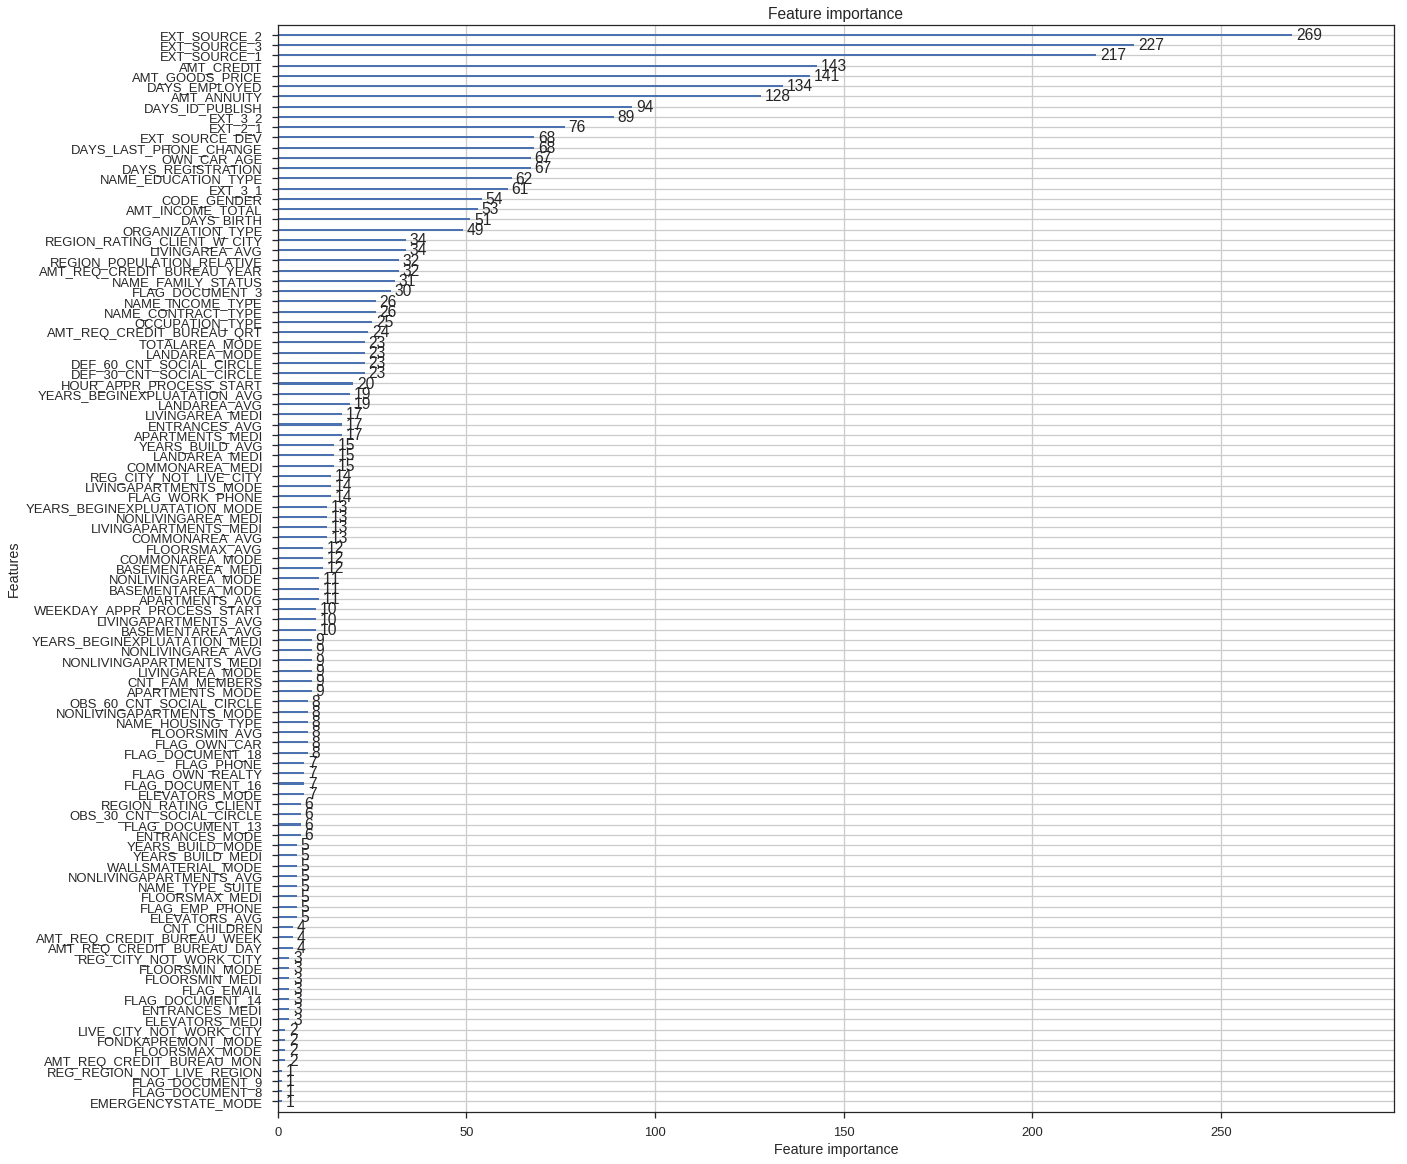

In [26]:
fig, ax = plt.subplots(1, figsize=(20, 20))
lgb.plot_importance(m, ax=ax);

### OOF Predictions

In [27]:
%%time

HOLDOUT_SCORE  = 0.754591 

oof_preds = m.predict(Xval)
joblib.dump(oof_preds, os.path.join(basepath, f'data/oof_sub/{MODEL_PRESET}_{HOLDOUT_SCORE}_preds.pkl'))

CPU times: user 1.29 s, sys: 36.1 ms, total: 1.33 s
Wall time: 646 ms


### Full Training

In [9]:
%%time

params = {
    'objective': 'binary',
    'learning_rate': .1 / 1.2,
    'metric': 'auc',
    'min_data_in_leaf': 20,
    'num_leaves': 31,
    'sub_feature': .7,
    'nthread': 4
}

BEST_ITERATION = 103

num_boost_round = int(BEST_ITERATION * 1.2)
ltrain = lgb.Dataset(Xtr, ytr, feature_name=features)

m           = lgb.train(params, ltrain, num_boost_round)
final_preds = m.predict(Xval)

CPU times: user 1min 2s, sys: 532 ms, total: 1min 3s
Wall time: 18.3 s


In [11]:
HOLDOUT_SCORE  = 0.754591 

sub_identifier = "%s-%s-%.5f" % (datetime.now().strftime('%Y%m%d-%H%M'), MODEL_PRESET, HOLDOUT_SCORE)

sub           = pd.read_csv('../data/raw/sample_submission.csv.zip')
sub['TARGET'] = final_preds

sub.to_csv(os.path.join(basepath, 'submissions/%s.csv'%(sub_identifier)), index=False)